d-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px; height: 163px">
</div>

# Classification

While linear regression models continuous variables, logistic regression classifies variables into two or more groups.  This lesson trains binomial and multi-class logistic regression models and examines evaluation metrics for classification tasks.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:<br>
* Identify classification versus regression tasks
* Train a binomial logistic regression model
* Use a confusion matrix to examine model performance
* Choose an evaluation metric specific to your use case
* Train a multi-class classification model

<iframe  
src="//fast.wistia.net/embed/iframe/1juy91ri2b?videoFoam=true"
style="border:1px solid #1cb1c2;"
allowtransparency="true" scrolling="no" class="wistia_embed"
name="wistia_embed" allowfullscreen mozallowfullscreen webkitallowfullscreen
oallowfullscreen msallowfullscreen width="640" height="360" ></iframe>
<div>
<a target="_blank" href="https://fast.wistia.net/embed/iframe/1juy91ri2b?seo=false">
  <img alt="Opens in new tab" src="https://files.training.databricks.com/static/images/external-link-icon-16x16.png"/>&nbsp;Watch full-screen.</a>
</div>

-sandbox
### The Logistic Regression Classifier

Linear regression models continuous variables where the result can be any value from negative infinity to infinity including decimals.  Many use cases involve modeling qualitative or categorical numbers instead, such as classifying a user on a website as fraudulent or not.

Classifiers fall into two main categories.  **Binomial, or binary, classification classifies data into two different categories,** such as whether or not a patient has a type of cancer.  **Multi-class classification classifies data into more than two categories,** such as predicting which category of object is in an image.

**Logistic regression models the _probability_ that a given set of features belong to a given category.**  Given that we're modeling a probability, results are bounded between 0 and 1.

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-1/logistic-regression.png" style="height: 400px; margin: 20px"/></div>

The above plot visualizes the relationship between breast cells and one input variable: thickness of cells.  Since the model returns the probabilities of an observation being of a given class, we can decide which cut-off threshold to use to classify a sample as cancerous or not.

In [0]:
%run "./Includes/Classroom-Setup"

Initialized classroom variables & functions...

Datasets are already mounted to /mnt/training from s3a://databricks-corp-training/common

Imported Test Library...

All done!

-sandbox
### Binomial Logistic Regression

Binomial logistic regression classifies data between two categories, giving us the probability (`p(X)`) associated with the observed data being of a particular category.  Formally, it differs from linear regression as follows:

&nbsp;&nbsp;&nbsp;&nbsp;Linear Regression:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`Y ≈ β<sub>0</sub> + β<sub>1</sub>X`<br>
&nbsp;&nbsp;&nbsp;&nbsp;Logistic Regression:&nbsp;&nbsp;&nbsp;`p(X) ≈ β<sub>0</sub> + β<sub>1</sub>X` 

Note that p(X) is in log odds.  This is explored further below.

Start by looking at the breast cancer dataset that contains information on breast cells and whether they are cancerous.

In [0]:
from pyspark.sql.functions import col

cols = ["index",
 "sample-code-number",
 "clump-thickness",
 "uniformity-of-cell-size",
 "uniformity-of-cell-shape",
 "marginal-adhesion",
 "single-epithelial-cell-size",
 "bare-nuclei",
 "bland-chromatin",
 "normal-nucleoli",
 "mitoses",
 "class"]

cancerDF = (spark.read  
  .option("HEADER", True)
  .option("inferSchema", True)
  .csv("/mnt/training/cancer/biopsy/biopsy.csv")
)

cancerDF = (cancerDF    # Add column names and drop nulls
  .toDF(*cols)
  .withColumn("bare-nuclei", col("bare-nuclei").isNotNull().cast("integer"))
)

display(cancerDF)

index,sample-code-number,clump-thickness,uniformity-of-cell-size,uniformity-of-cell-shape,marginal-adhesion,single-epithelial-cell-size,bare-nuclei,bland-chromatin,normal-nucleoli,mitoses,class
1,1000025,5,1,1,1,2,1,3,1,1,benign
2,1002945,5,4,4,5,7,1,3,2,1,benign
3,1015425,3,1,1,1,2,1,3,1,1,benign
4,1016277,6,8,8,1,3,1,3,7,1,benign
5,1017023,4,1,1,3,2,1,3,1,1,benign
6,1017122,8,10,10,8,7,1,9,7,1,malignant
7,1018099,1,1,1,1,2,1,3,1,1,benign
8,1018561,2,1,2,1,2,1,3,1,1,benign
9,1033078,2,1,1,1,2,1,1,1,5,benign
10,1033078,4,2,1,1,2,1,2,1,1,benign


-sandbox
Classification models are sensitive to how much data we have in each class.  View the class balance by grouping the data on our label.

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> In the case of unbalanced classes, one solution is to use to pass weights into the model allowing for a greater penalty for misclassifying the underrepresented class.

In [0]:
display(cancerDF.groupby("class").count())

class,count
malignant,241
benign,458


Our classes are well balanced.  Turn the label into a numerical value and create a column `feature` for just `clump-thickness`.

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# create an Indexer
indexer = StringIndexer(inputCol="class", outputCol="is-malignant")

# Train the model
cancerIndexedDF = indexer.fit(cancerDF).transform(cancerDF)

# create the assembler
assembler = VectorAssembler(inputCols = ["clump-thickness"], outputCol = "feature" )

# tranform the Index dataframe
cancerIndexedAssembledDF = assembler.transform(cancerIndexedDF)

display(cancerIndexedAssembledDF)

index,sample-code-number,clump-thickness,uniformity-of-cell-size,uniformity-of-cell-shape,marginal-adhesion,single-epithelial-cell-size,bare-nuclei,bland-chromatin,normal-nucleoli,mitoses,class,is-malignant,feature
1,1000025,5,1,1,1,2,1,3,1,1,benign,0.0,"List(1, 1, List(), List(5.0))"
2,1002945,5,4,4,5,7,1,3,2,1,benign,0.0,"List(1, 1, List(), List(5.0))"
3,1015425,3,1,1,1,2,1,3,1,1,benign,0.0,"List(1, 1, List(), List(3.0))"
4,1016277,6,8,8,1,3,1,3,7,1,benign,0.0,"List(1, 1, List(), List(6.0))"
5,1017023,4,1,1,3,2,1,3,1,1,benign,0.0,"List(1, 1, List(), List(4.0))"
6,1017122,8,10,10,8,7,1,9,7,1,malignant,1.0,"List(1, 1, List(), List(8.0))"
7,1018099,1,1,1,1,2,1,3,1,1,benign,0.0,"List(1, 1, List(), List(1.0))"
8,1018561,2,1,2,1,2,1,3,1,1,benign,0.0,"List(1, 1, List(), List(2.0))"
9,1033078,2,1,1,1,2,1,1,1,5,benign,0.0,"List(1, 1, List(), List(2.0))"
10,1033078,4,2,1,1,2,1,2,1,1,benign,0.0,"List(1, 1, List(), List(4.0))"


Train the logistic regression model using only the input feature `clump-thickness` and look at the resulting coefficient.

In [0]:
from pyspark.ml.classification import LogisticRegression

# create a Logistic regression
logr = LogisticRegression(featuresCol = "feature", labelCol = "is-malignant")

# train the model
logrModel = logr.fit(cancerIndexedAssembledDF)

print("β0 (intercept): {}".format(logrModel.intercept))
print("β1 (coefficient for rm): {}".format(logrModel.coefficients[0]))

β0 (intercept): -5.160167563514623
β1 (coefficient for rm): 0.9354592950920231

-sandbox
### Model Interpretation

In linear regression, increasing a given feature `X` by one unit increased our prediction by `X` multiplied by the corresponding coefficient.  In logistic regression, increasing a given feature `X` by one unit increases the log odds by the corresponding coefficient.  In other words, the odds that a clump size of 9 is cancerous is :

&nbsp;&nbsp;&nbsp;&nbsp;`odds of cancer = ε<sup>β<sub>0</sub> + β<sub>1</sub>X</sup>`<br>
&nbsp;&nbsp;&nbsp;&nbsp;`odds of cancer = ε<sup>-5.2 + .94 x 9</sup>`<br>
&nbsp;&nbsp;&nbsp;&nbsp;`odds of cancer = ε<sup>3.26</sup>`<br>
&nbsp;&nbsp;&nbsp;&nbsp;`odds of cancer = 26`<br>

The odds of cancer with a clump size of 9 is therefore 26 to 1, or .96.

Take a look at how the model makes predictions.  The `probability` column gives us the probability of being of class 0 and of being in class 1.

In [0]:
from pyspark.sql.functions import desc

# transform Assembled dataframe
transformedDF = logrModel.transform(cancerIndexedAssembledDF)

display(transformedDF
  .select("clump-thickness", "class", "is-malignant", "probability")
  .distinct()
  .orderBy(desc("clump-thickness"))
)

clump-thickness,class,is-malignant,probability
10,malignant,1.0,"List(1, 2, List(), List(0.014855394285289047, 0.9851446057147109))"
9,malignant,1.0,"List(1, 2, List(), List(0.037006036608596464, 0.9629939633914036))"
8,malignant,1.0,"List(1, 2, List(), List(0.08919475972944649, 0.9108052402705534))"
8,benign,0.0,"List(1, 2, List(), List(0.08919475972944649, 0.9108052402705534))"
7,malignant,1.0,"List(1, 2, List(), List(0.19971964496083733, 0.8002803550391626))"
7,benign,0.0,"List(1, 2, List(), List(0.19971964496083733, 0.8002803550391626))"
6,benign,0.0,"List(1, 2, List(), List(0.3887455731458703, 0.6112544268541297))"
6,malignant,1.0,"List(1, 2, List(), List(0.3887455731458703, 0.6112544268541297))"
5,malignant,1.0,"List(1, 2, List(), List(0.6184256108204332, 0.38157438917956676))"
5,benign,0.0,"List(1, 2, List(), List(0.6184256108204332, 0.38157438917956676))"


Calculate this value manually using the intercept and coefficient.

In [0]:
from math import exp

odds = exp(-5.2 + .94 * 9)     # Exponentiate the formula since logistic regression is log odds
probability = 1 - (1 / odds)   # Convert odds to probability

print("Prediction for odds of cancer: {} to 1".format( round(odds, 1) ))
print("Prediction for probability of cancer: {}".format(probability))

Prediction for odds of cancer: 26.0 to 1
Prediction for probability of cancer: 0.9616116019824479

Take a look at how the model predicted the probability.

In [0]:
(transformedDF
.filter(col("clump-thickness")==9)
.select("probability")
.first()[0]
)

Out[12]: DenseVector([0.037, 0.963])

-sandbox
### Model Performance

A confusion matrix is a table that reports the number of false positives, false negatives, true positives, and true negatives.  This is the basis of a number of different evaluation metrics such as accuracy, precision, and area under the ROC curve.  For instance, accuracy is calculated by adding the true positives and true negatives and dividing by the total number of records.  The best accuracy metric for a given use case depends on how we want to optimize between true and false predictions.

For the model trained above, the confusion matrix looks as follows:

| n = 699           | Predicted Positive   | Predicted Negative   |
|-------------------|----------------------|----------------------|
| Actually Positive | True Positives:  165 | False Positives:  21 |
| Actually Negative | False Negatives: 76  | True Negatives:  437 |

Various model evaluation metrics are based around this table.

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> See <a href="https://en.wikipedia.org/wiki/Confusion_matrix" target="_blank">the Wikipedia article on Confusion Matrix</a> for more information on various evaluation metrics.

Print out the confusion matrix.

In [0]:
n = transformedDF.count()
TP = transformedDF.filter((col("is-malignant") == 1) & (col("prediction") == 1)).count()
FP = transformedDF.filter((col("is-malignant") == 0) & (col("prediction") == 1)).count()
FN = transformedDF.filter((col("is-malignant") == 1) & (col("prediction") == 0)).count()
TN = transformedDF.filter((col("is-malignant") == 0) & (col("prediction") == 0)).count()

print("n = {}\t\t\tPredicted Positive \tPredicted Negative".format(n))
print("Actually Positive\t{} \t\t\t{}".format(TP, FP))
print("Actually Negative\t{} \t\t\t{}".format(FN, TN))

n = 699 Predicted Positive Predicted Negative
Actually Positive	165 21
Actually Negative	76 437

-sandbox
One way of visualizing the trade-off between true positives and false positives is by plotting them on a ROC Curve.

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> See <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic" target="_blank">the Wikipedia article on ROC Curves</a> for more information.

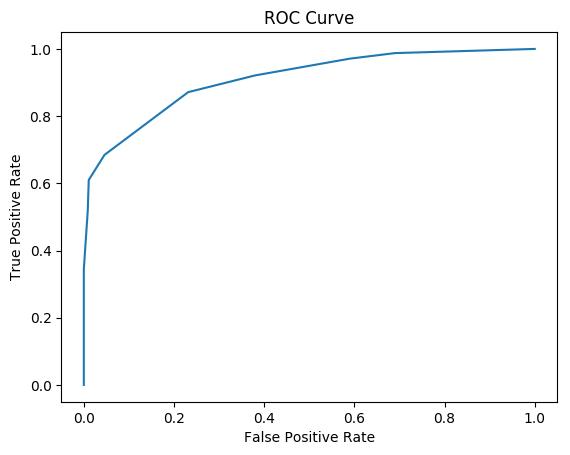

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

falsePositives, truePositives = [], []

for row in logrModel.summary.roc.collect():
  falsePositives.append(row.FPR)
  truePositives.append(row.TPR)

fig = plt.figure()

plt.plot(falsePositives, truePositives)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

display(fig)

The associated evaluation metric takes the total area under this curve, which is bounded between 0 and 1.

In [0]:
# Plot ROC using logrModel
logrModel.summary.areaUnderROC

Out[15]: 0.9098416351084454

Retrain the model using all of the relevant features.  This excludes the index and sequence number, which would not provide relevant information to our model.

In [0]:
assembler = VectorAssembler(inputCols=cols[2:-1], outputCol="features")
cancerIndexedAssembledDF2 = assembler.transform(cancerIndexedDF)

# create logistic regression 
logr = LogisticRegression(featuresCol="features", labelCol="is-malignant")

# train the model
logrModel2 = logr.fit(cancerIndexedAssembledDF2)

logrModel2.coefficients

Out[16]: DenseVector([0.5776, -0.0116, 0.5679, 0.3137, 0.1306, 0.0, 0.58, 0.1232, 0.6079])

Take a look at how the area under the ROC curve has improved.

In [0]:
#TODO
logrModel2.summary.areaUnderROC

Out[17]: 0.9929650836217362

As we can see, the model performs relatively well at predicting cancer based upon the available features.

### Multi-Class Classification

Classification between multiple classes using logistic regression is known as multi-class or **multinomial logistic regression.**  While the underlying mathematics are quite different, the Spark API is the same.  To predict between different classes, set the `family` argument for `LogisticRegression` to `multinomial`.  This model then provides probabilities associated with each class.

Continue on to the exercise where you'll train a multinomial model.

## Exercise: Training Multinomial Logistic Regression

Train a multinomial logistic regression model using the Iris dataset.

### Step 1: Import the Data

Import the data and clean the column names, which can cause issues for Spark.

In [0]:
irisDF = (spark.read
  .option("INFERSCHEMA", True)
  .option("HEADER", True)
  .csv("/mnt/training/iris/iris.csv")
  .drop("_c0")
)

cols = [col.replace(".", "-").lower() for col in irisDF.columns]
irisDF = irisDF.toDF(*cols)

display(irisDF)

sepal-length,sepal-width,petal-length,petal-width,species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


-sandbox
### Step 2: Create a Pipeline

Create a pipeline of three stages:

1. `indexer`: a `StringIndexer` that takes `species` as an input and outputs `speciesClass`
2. `assembler`: a `VectorAssembler` that takes all the features in the dataset and outputs `features`
3. `multinomialRegression`: a `LogisticRegression` that takes `features` and uses the `multinomial` family

<img alt="Side Note" title="Side Note" style="vertical-align: text-bottom; position: relative; height:1.75em; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> See the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=vectorassembler#pyspark.ml.classification.LogisticRegression" target="_blank">LogisticRegression</a> documentation for more details.

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="species", outputCol = "speciesClass")
assembler = VectorAssembler(inputCols=["sepal-length","sepal-width","petal-length","petal-width"], outputCol = "features")
multinomialRegression = LogisticRegression (featuresCol="features", labelCol="speciesClass", family="multinomial")

pipeline = Pipeline(stages=[
            indexer,
            assembler,
            multinomialRegression
              ])


In [0]:
# TEST - Run this cell to test your solution
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler

dbTest("ML1-P-07-02-01", True, type(indexer) == type(StringIndexer()))
dbTest("ML1-P-07-02-02", True, indexer.getInputCol() == 'species')
dbTest("ML1-P-07-02-03", True, indexer.getOutputCol() == 'speciesClass')

dbTest("ML1-P-07-02-04", True, type(assembler) == type(VectorAssembler()))
dbTest("ML1-P-07-02-05", True, assembler.getInputCols() == irisDF.columns[:-1])
dbTest("ML1-P-07-02-06", True, assembler.getOutputCol() == 'features')

dbTest("ML1-P-07-02-07", True, type(multinomialRegression) == type(LogisticRegression()))
dbTest("ML1-P-07-02-08", True, multinomialRegression.getLabelCol() == "speciesClass")
dbTest("ML1-P-07-02-09", True, multinomialRegression.getFeaturesCol() == 'features')

dbTest("ML1-P-07-02-10", True, type(pipeline) == type(Pipeline()))

print("Tests passed!")

Tests passed!

### Step 3: Train the Model and Transform the Dataset

Train the model and save the results to `multinomialModel` and save the transformed dataset to `irisTransformedDF`.

In [0]:
# TODO
multinomialModel = pipeline.fit(irisDF)
irisTransformedDF = multinomialModel.transform(irisDF)

In [0]:
# TEST - Run this cell to test your solution
dbTest("ML1-P-07-03-01", True, "prediction" in irisTransformedDF.columns)

print("Tests passed!")

Tests passed!

Notice how we have probabilities and raw log odds predictions for all three classes.

In [0]:
display(irisTransformedDF)

sepal-length,sepal-width,petal-length,petal-width,species,speciesClass,features,rawPrediction,probability,prediction
5.1,3.5,1.4,0.2,setosa,2.0,"List(1, 4, List(), List(5.1, 3.5, 1.4, 0.2))","List(1, 3, List(), List(-5.330487448205378, -67.06433682139603, 72.39482426960141))","List(1, 3, List(), List(1.755197601436475E-34, 2.7142877541487892E-61, 1.0))",2.0
4.9,3.0,1.4,0.2,setosa,2.0,"List(1, 4, List(), List(4.9, 3.0, 1.4, 0.2))","List(1, 3, List(), List(1.6409561860558632, -56.259436765639734, 54.61848057958386))","List(1, 3, List(), List(9.820949796683436E-24, 7.019922734422628E-49, 1.0))",2.0
4.7,3.2,1.3,0.2,setosa,2.0,"List(1, 4, List(), List(4.7, 3.2, 1.3, 0.2))","List(1, 3, List(), List(-2.8388515208370997, -62.52528067478171, 65.36413219561881))","List(1, 3, List(), List(2.3978417774109022E-30, 2.872987236061863E-56, 1.0))",2.0
4.6,3.1,1.5,0.2,setosa,2.0,"List(1, 4, List(), List(4.6, 3.1, 1.5, 0.2))","List(1, 3, List(), List(-1.5951690072242464, -58.481177686198194, 60.07634669342241))","List(1, 3, List(), List(1.645890886882168E-27, 3.2443027436108414E-52, 1.0))",2.0
5.0,3.6,1.4,0.2,setosa,2.0,"List(1, 4, List(), List(5.0, 3.6, 1.4, 0.2))","List(1, 3, List(), List(-7.522565434325827, -69.67797856073203, 77.20054399505783))","List(1, 3, List(), List(1.6040617583194474E-37, 1.627301946487329E-64, 1.0))",2.0
5.4,3.9,1.7,0.4,setosa,2.0,"List(1, 4, List(), List(5.4, 3.9, 1.7, 0.4))","List(1, 3, List(), List(-9.09669383765818, -67.75652066483052, 76.85321450248871))","List(1, 3, List(), List(4.703585986395942E-38, 1.5732219144040733E-63, 1.0))",2.0
4.6,3.4,1.4,0.3,setosa,2.0,"List(1, 4, List(), List(4.6, 3.4, 1.4, 0.3))","List(1, 3, List(), List(-6.194404260154176, -64.19897732634955, 70.3933815865037))","List(1, 3, List(), List(5.474534860677777E-34, 3.5259911491156826E-59, 1.0))",2.0
5.0,3.4,1.5,0.2,setosa,2.0,"List(1, 4, List(), List(5.0, 3.4, 1.5, 0.2))","List(1, 3, List(), List(-4.182456669244587, -64.0587942632825, 68.24125093252708))","List(1, 3, List(), List(3.521951974207875E-32, 3.48995973132365E-58, 1.0))",2.0
4.4,2.9,1.4,0.2,setosa,2.0,"List(1, 4, List(), List(4.4, 2.9, 1.4, 0.2))","List(1, 3, List(), List(0.41393734674116445, -55.58577386138114, 55.171836514639985))","List(1, 3, List(), List(1.655566198068865E-24, 7.917370797402245E-49, 1.0))",2.0
4.9,3.1,1.5,0.1,setosa,2.0,"List(1, 4, List(), List(4.9, 3.1, 1.5, 0.1))","List(1, 3, List(), List(-0.24872262187257732, -59.702884859447394, 59.95160748131994))","List(1, 3, List(), List(7.166858457698291E-27, 1.0832139427662665E-52, 1.0))",2.0


## Review
**Question:** What is the difference between Classification and Regression?  
**Answer:** Classification models a discrete output variable such as whether a patient has cancer.  In this case, there are two possible classes a given observation falls into.  In classification tasks, we predict the probability of a given observations being of a given class.  We then choose a cutoff threshold, such as classifying all values with a probability over 0.5 as being part of a given task.  Regression models continuous variables such as the lifetime value of a customer.  The term _logistic regression_ can be confusing since it's being used for classification.  While we could use linear regression for a less precise way of predicting probabilities, logistic regression bounds the results between 0 and 1.  Combined with the decision rule (that is, the cutoff threshold), logistic regression becomes a classification algorithm.

**Question:** How do I interpret the coefficients in logistic regression?  
**Answer:** In the case of linear regression, the coefficient represents the linear increase or decrease in the prediction for a given observed value.  Logistic regression is similar but a bit less intuitive.  In logistic regression, coefficients indicate the change in log odds to our final prediction.  See the walk-through above for details.

**Question:** What are the various ways that I can evaluate model performance in binomial classification?  
**Answer:** Evaluating model performance in the case of binomial regression is more complex than in the case of regression, where most metrics are based around the distance between the true and predicted values.  These metrics are different trade-offs between true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).  Some common metrics include:
0. Sensitivity = TP / (TP + FN)
0. Specificity = TN / (TN + FP)
0. Precision = TP / (TP + FP)
0. Accuracy = (TP + TN) / (TP + TN + FP + FN)

## Next Steps

Start the next lesson, [Model Selection]($./08-Model-Selection).

-sandbox
&copy; 2019 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="http://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="http://help.databricks.com/">Support</a>